# Quantum ROM Notebook

## Overview
This notebook walks through the develop of a QROM function; a Qiskit function that, in essence, takes a boolean function, a linear transformation of $\mathbb{F}_2:= \mathbb{Z}/2\mathbb{Z}$ vector spaces 
$$ f: \mathbb{F}_2^n \rightarrow \mathbb{F}_2^d,$$ 
and outputs an associated quantum circuit $U$. The circuit must act as an oracle, performing the following operation: 
$$ U|x\rangle_n|0\rangle_d = |x\rangle_n |f(x)\rangle_d. $$ 

We will do one of the `straightforward' implementation of the task, by creating a function 'build_qrom' that takes in the function input as a dictionary, effectively describing the truth table of the function, and then translating this information into an equivalent quantum circuit. 

Obviously, this is computationally intensive to say the least, but it gets the job done for our current purposes (and the fact that I don't have as much time right now as for the last mini progject).

I plan on eventually updating this code so that it is compatible with the lamba calculus, taking such a function and ``deconstructing" it into indecomposable logical operations, and then including the equivalent quantum gate to the circuit, effectively acting as a "quantum compiler" (if that is the correct way of thinking of such an operation). I believe this would get such a function to be closer to a state-of-the-art functino to complete the given task. 



 

In [15]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister, Gate
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import numpy as np

## add_oracle_entry

We begin by defining a function, called `add_oracle_entry', whose purpose is to build the quantum circuit for a $\textit{a single row}$ of the truth table corresponding to a given function $f$. Rather than taking the entire function as input, it only takes the input and output values of the row in the truth table. This is because the function is not meant to be used in isolation, but will later be used in a loop to iterate through $\textit{every}$ row of the truth table corresponding to $f$, thus building the complete quantum circuit. 
We explain the precise mechanics of the function within the in-line comments of the code. 

In [16]:
# Cell 2: Helper Function
def add_oracle_entry(circuit: QuantumCircuit, q_input: QuantumRegister, q_output: QuantumRegister, input_str: str, output_str: str):
    """
    Apllies the function at one input / value according to the corresponding 
    strings f(input_str) = output_str, and modifies the QuantumRegister objects accordingly.

    Args: 
        circuit: QuantumCircuit, quantum circuit corresponding to given line of truth table for f
        q_input: QuantumRegister, corresponding to input qubit
        q_output: QuantumRegister corresponding to output qubit
        input_str: str, string describing given input of the row of truth table for f
        output_str: str, string describing f(input_str)
    
    N.B. the function does not offer any return, as it is meant to manipulate objects defined
    internally in a larger function. 
    """
    
    # Identify dimensions of source and targer vector spaces
    n = len(q_input)
    d = len(q_output)
    
    # Reverse string orders to correspond to Qiskit convention
    input_str_r = input_str[::-1]
    output_str_r = output_str[::-1]

    """
    We apply X gates to all input qubits that are '0' in the reverse string
    to ensure that resulting string is all '1's, to be compatible with MCX
    in the case that output needs to be 'flipped'. 
    """
    control_flips = []
    for i in range(n):
        if input_str_r[i] == '0':
            circuit.x(q_input[i])
            control_flips.append(i)

    # Find all '1's in the reversed output string
    target_indices = [j for j, bit in enumerate(output_str_r) if bit == '1']

    
    # Apply one MCX gate for each '1' in the reversed output string
    for j in target_indices:
        circuit.mcx(control_qubits=q_input, target_qubit=q_output[j])

    # Return flipped quibits to initial input state
    for i in control_flips:
        circuit.x(q_input[i])

## build_QROM

Now that we have defined the initial 'add_oracle_entry', our main function, 'build_QROM', is easy to describe as it simply loops through the truth table corresponding to a Boolean function $f$, defined here using a Python dictionary, and applies the 'add_oracle_entry' function to every row of the truth table. 

In [17]:
def build_qrom(n: int, d: int, f_map: dict):
    """
    Builds a QROM circuit for a boolean function f: F_2^n -> F_2^d, 
    using the truth table corresponding to that function, 
    encoded as a Python dictionary. 
    
    Args:
        n: Dimension of source space / number of input qubits.
        d: Dimension of target space / umber of output qubits.
        f_map: A dictionary representing the function f, viewing the function as a subset of F_2^n x F_2^d

    Returns:
        The QuantumCircuit object representing the function f. 
    """
    # Initialize the the input and output qubits according to dimension of 
    # source and target space of the function f
    q_input = QuantumRegister(n, name='in')
    q_output = QuantumRegister(d, name='out')
    circuit = QuantumCircuit(q_output, q_input)
        
    # Loop through all entries in the source / target and modify the quantum circuit accordingly,
    # using the 'add_oracle_entry' function to do so. 
    for input_str, output_str in f_map.items():
        circuit.barrier() 
        # Use 'add_oracle_entry' according to each entry in the source / target
        add_oracle_entry(circuit, q_input, q_output, input_str, output_str)
    
    # Circuit barriers are added at every step only for ease of readability in circuit diagram
    circuit.barrier()
    
    return circuit

## Example 

Now, let's apply our function to a simple example, with a mapping $f: \mathbb{F}_2^2 \to \mathbb{F}_2^1$. We consider the function $f$ corresponding to the following truth table:
$$\begin{bmatrix} 00 \mapsto 0 \\ 01 \mapsto 0 \\ 10 \mapsto 0 \\ 11 \mapsto 1 \end{bmatrix}$$
We simply build a dictionary that encodes this function, and the feed it into our 'build_qrom' function, drawing the circuit to see how it encodes the function in the quantum context. 

This is essentially the most basic non-trivial example we can do, and we will do the required $n = 3$ example next. 

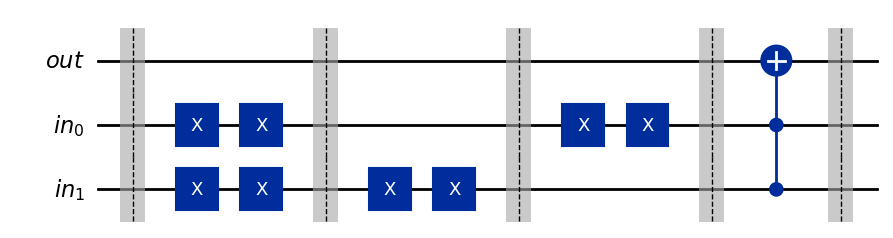

In [18]:
# Set parameters according to source and target of $f$
n_simple = 2
d_simple = 1

# Describe the function $f$ using a dictionary 
f_map_simple = {
    "00": "0",
    "01": "0",
    "10": "0",
    "11": "1"
}

# Building the circuit using our Python function 'build_qrom', defined above: 
simple_circuit = build_qrom(n_simple, d_simple, f_map_simple)

# Drawing the circuit
simple_circuit.draw('mpl', style='iqx')

Now we do the required $n=3$ case, encoding the following function:
$$ f(x) = 3x\ (\text{mod} 4).$$

/Users/james/Documents/anaconda3/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:272: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /Users/james/Documents/anaconda3/lib/python3.12/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(


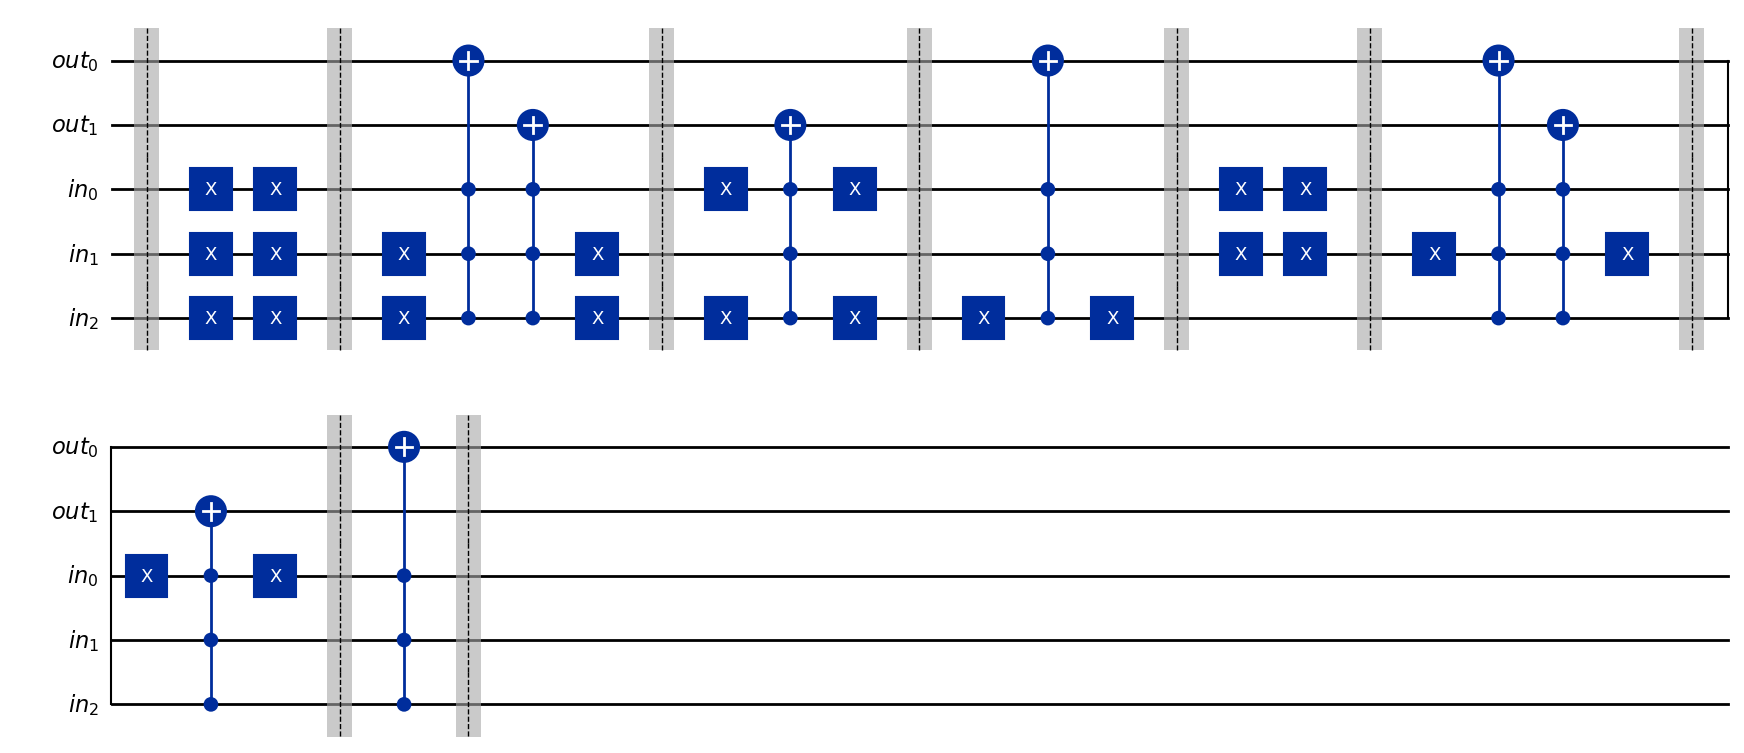

In [19]:
# Set parameters according to source and target of $f$
n_simple = 3
d_simple = 2

# Describe the function $f$ using a dictionary 
f_map_simple = {
    "000": "00",  # 3*0=0. 0%4 = 0
    "001": "11",  # 3*1=3. 3%4 = 3
    "010": "10",  # 3*2=6. 6%4 = 2
    "011": "01",  # 3*3=9. 9%4 = 1
    "100": "00",  # 3*4=12. 12%4 = 0
    "101": "11",  # 3*5=15. 15%4 = 3
    "110": "10",  # 3*6=18. 18%4 = 2
    "111": "01"   # 3*7=21. 21%4 = 1
}

# Building the circuit using our Python function 'build_qrom', defined above: 
simple_circuit = build_qrom(n_simple, d_simple, f_map_simple)

# Drawing the circuit
simple_circuit.draw('mpl', style='iqx')